In [1]:
from glob import glob

import polars as pl
from tqdm import tqdm

In [ ]:
base_dir = "/large_storage/ctc/public/scBasecamp/GeneFull_Ex50pAS/GeneFull_Ex50pAS"
out_dir = "/large_storage/ctc/public/scBasecamp/meta_analysis/cell_statistics"
paths = glob(f"{base_dir}/*/*.h5ad")

# import scanpy as sc
# unable_to_process = []

# for path in tqdm(paths):
#     species = path.split("/")[-2]
#     accession = path.split("/")[-1].split(".h5ad")[0]

#     adata = sc.read_h5ad(path, backed=True)

#     if "gene_count" not in adata.obs.columns or "umi_count" not in adata.obs.columns:
#         print(f"Unable to process: {species} {accession}")
#         unable_to_process.append([species, accession])
#         continue

#     frame = (
#         pl.DataFrame(adata.obs)
#         .with_columns(
#             species=pl.lit(species),
#         )
#         .insert_column(0, pl.Series("cid", np.arange(adata.obs.shape[0])))
#     )
#     frame.write_parquet(f"{out_dir}/{species}.{accession}.parquet")


In [3]:
pl.enable_string_cache()

all_parquet = glob(f"{out_dir}/*.parquet")

frame = pl.concat([pl.read_parquet(parquet_path) for parquet_path in tqdm(all_parquet)])
frame

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30387/30387 [00:19<00:00, 1522.65it/s]


cid,gene_count,umi_count,SRX_accession,species
i64,i64,f32,cat,str
0,279,589.0,"""SRX20568526""","""Homo_sapiens"""
1,723,1480.0,"""SRX20568526""","""Homo_sapiens"""
2,1227,3903.0,"""SRX20568526""","""Homo_sapiens"""
3,10469,157686.0,"""SRX20568526""","""Homo_sapiens"""
4,6524,37051.0,"""SRX20568526""","""Homo_sapiens"""
…,…,…,…,…
10726,613,801.0,"""SRX14578794""","""Mus_musculus"""
10727,583,731.0,"""SRX14578794""","""Mus_musculus"""
10728,874,1409.0,"""SRX14578794""","""Mus_musculus"""


In [4]:
stats_data = (
    frame.group_by(["species", "SRX_accession"])
    .agg(
        q1=pl.col("umi_count").quantile(0.25),
        med=pl.col("umi_count").quantile(0.5),
        q3=pl.col("umi_count").quantile(0.75),
        min_umi=pl.col("umi_count").min(),
        max_umi=pl.col("umi_count").max(),
    )
    .with_columns(iqr=pl.col("q3") - pl.col("q1"))
    .with_columns(
        whislo=pl.max_horizontal(pl.col("q1") - 1.5 * pl.col("iqr"), pl.col("min_umi")),
        whishi=pl.min_horizontal(pl.col("q3") + 1.5 * pl.col("iqr"), pl.col("max_umi")),
    )
    .sort(["species", "med"])
)
stats_data

species,SRX_accession,q1,med,q3,min_umi,max_umi,iqr,whislo,whishi
str,cat,f32,f32,f32,f32,f32,f32,f32,f32
"""Arabidopsis_thaliana""","""SRX19498739""",1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
"""Arabidopsis_thaliana""","""SRX19498763""",1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
"""Arabidopsis_thaliana""","""SRX19498762""",1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
"""Arabidopsis_thaliana""","""SRX19498740""",1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
"""Arabidopsis_thaliana""","""SRX26627910""",45.0,62.0,93.0,32.0,700.0,48.0,32.0,165.0
…,…,…,…,…,…,…,…,…,…
"""Zea_mays""","""SRX8487984""",1113.0,3689.0,12828.0,692.0,334004.0,11715.0,692.0,30400.5
"""Zea_mays""","""SRX15010907""",2035.0,4548.0,8305.0,500.0,72976.0,6270.0,500.0,17710.0
"""Zea_mays""","""SRX15010906""",2021.0,4591.0,8185.0,500.0,44505.0,6164.0,500.0,17431.0


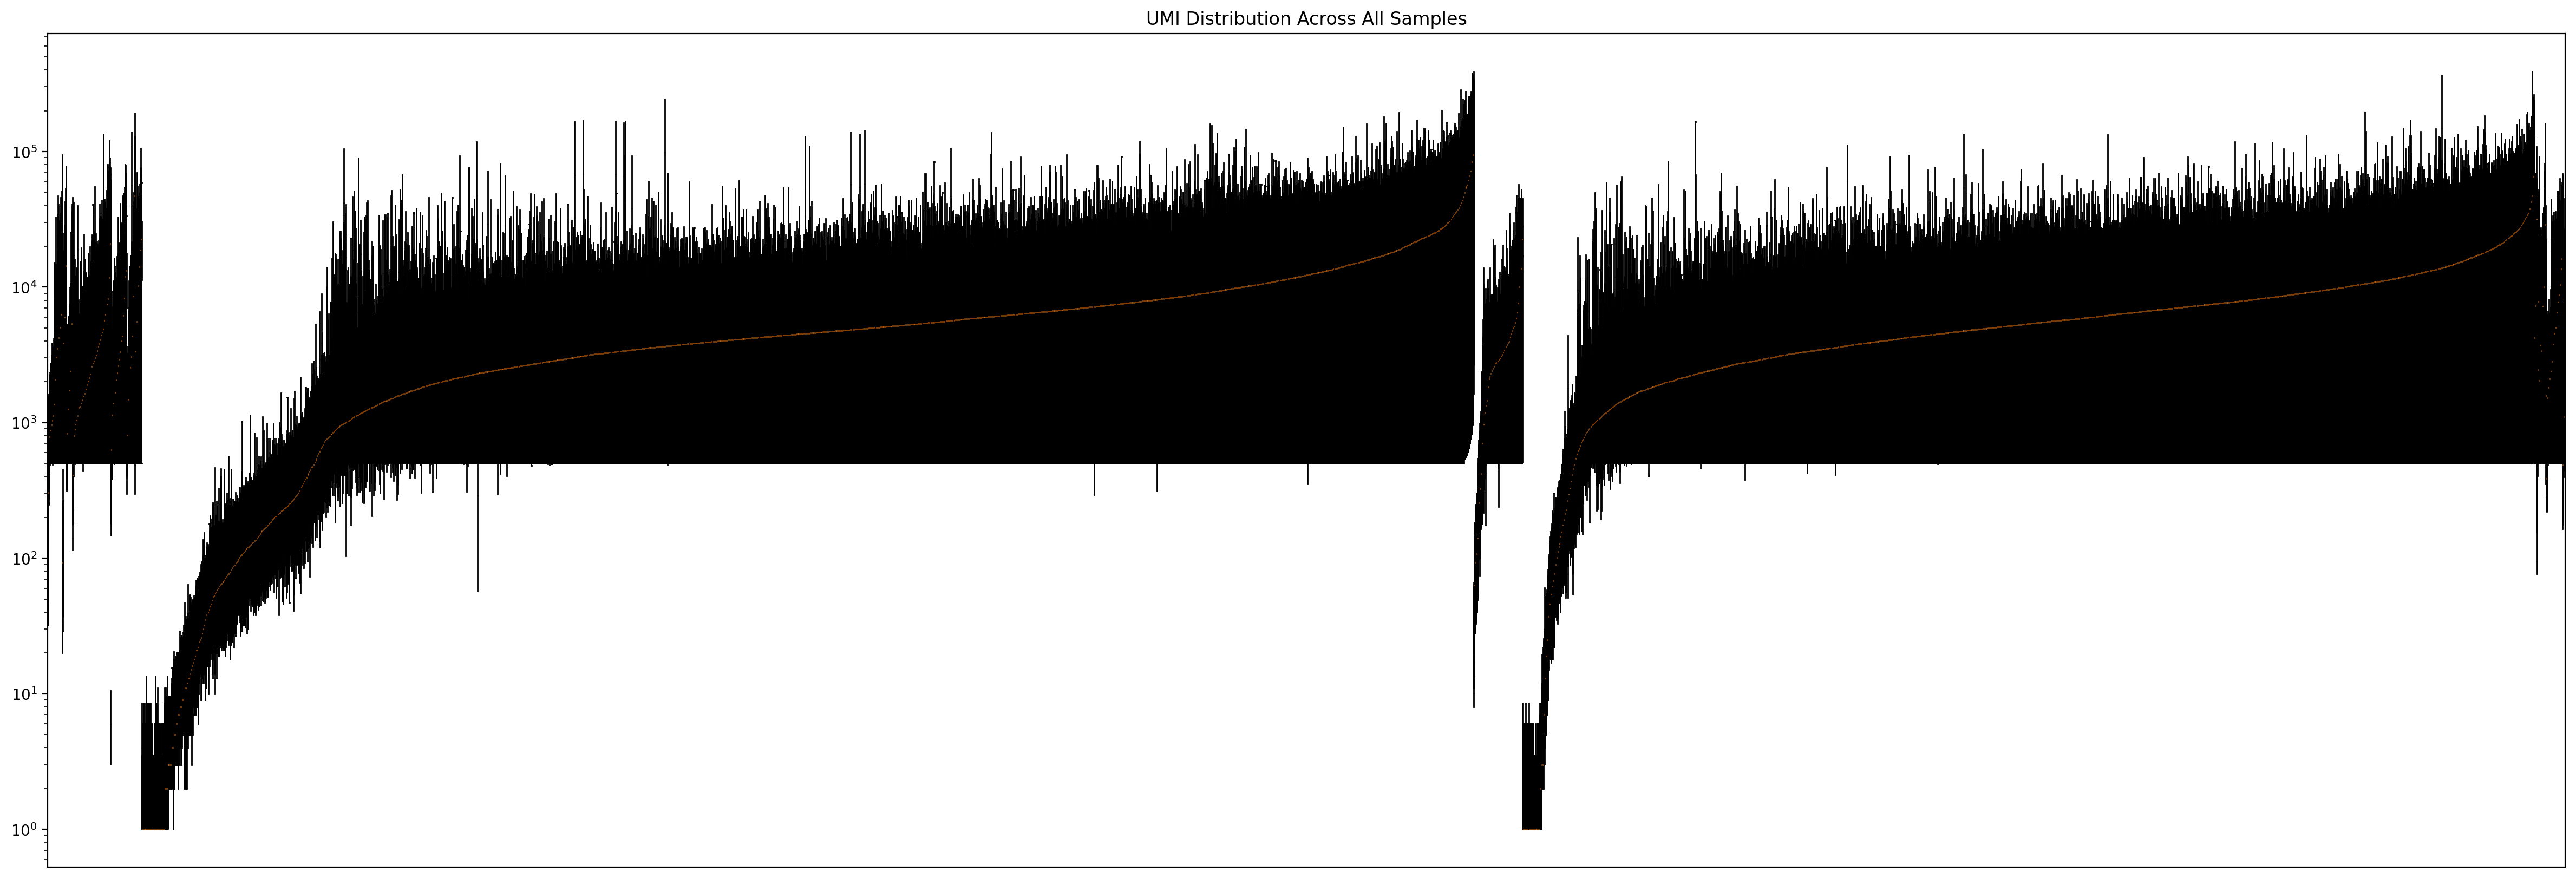

In [5]:
import matplotlib.pyplot as plt

# stats_list = stats_data.head(1000).to_dicts()
stats_list = stats_data.to_dicts()

fig, ax = plt.subplots(figsize=(30, 10), dpi=200)
bplot = ax.bxp(stats_list, showfliers=False, patch_artist=True)

for i, box in enumerate(bplot["boxes"]):
    color = "green" if i % 2 == 0 else "red"
    box.set(facecolor=color)

plt.yscale("log", base=10)
plt.xticks([])
plt.title("UMI Distribution Across All Samples")
plt.show()

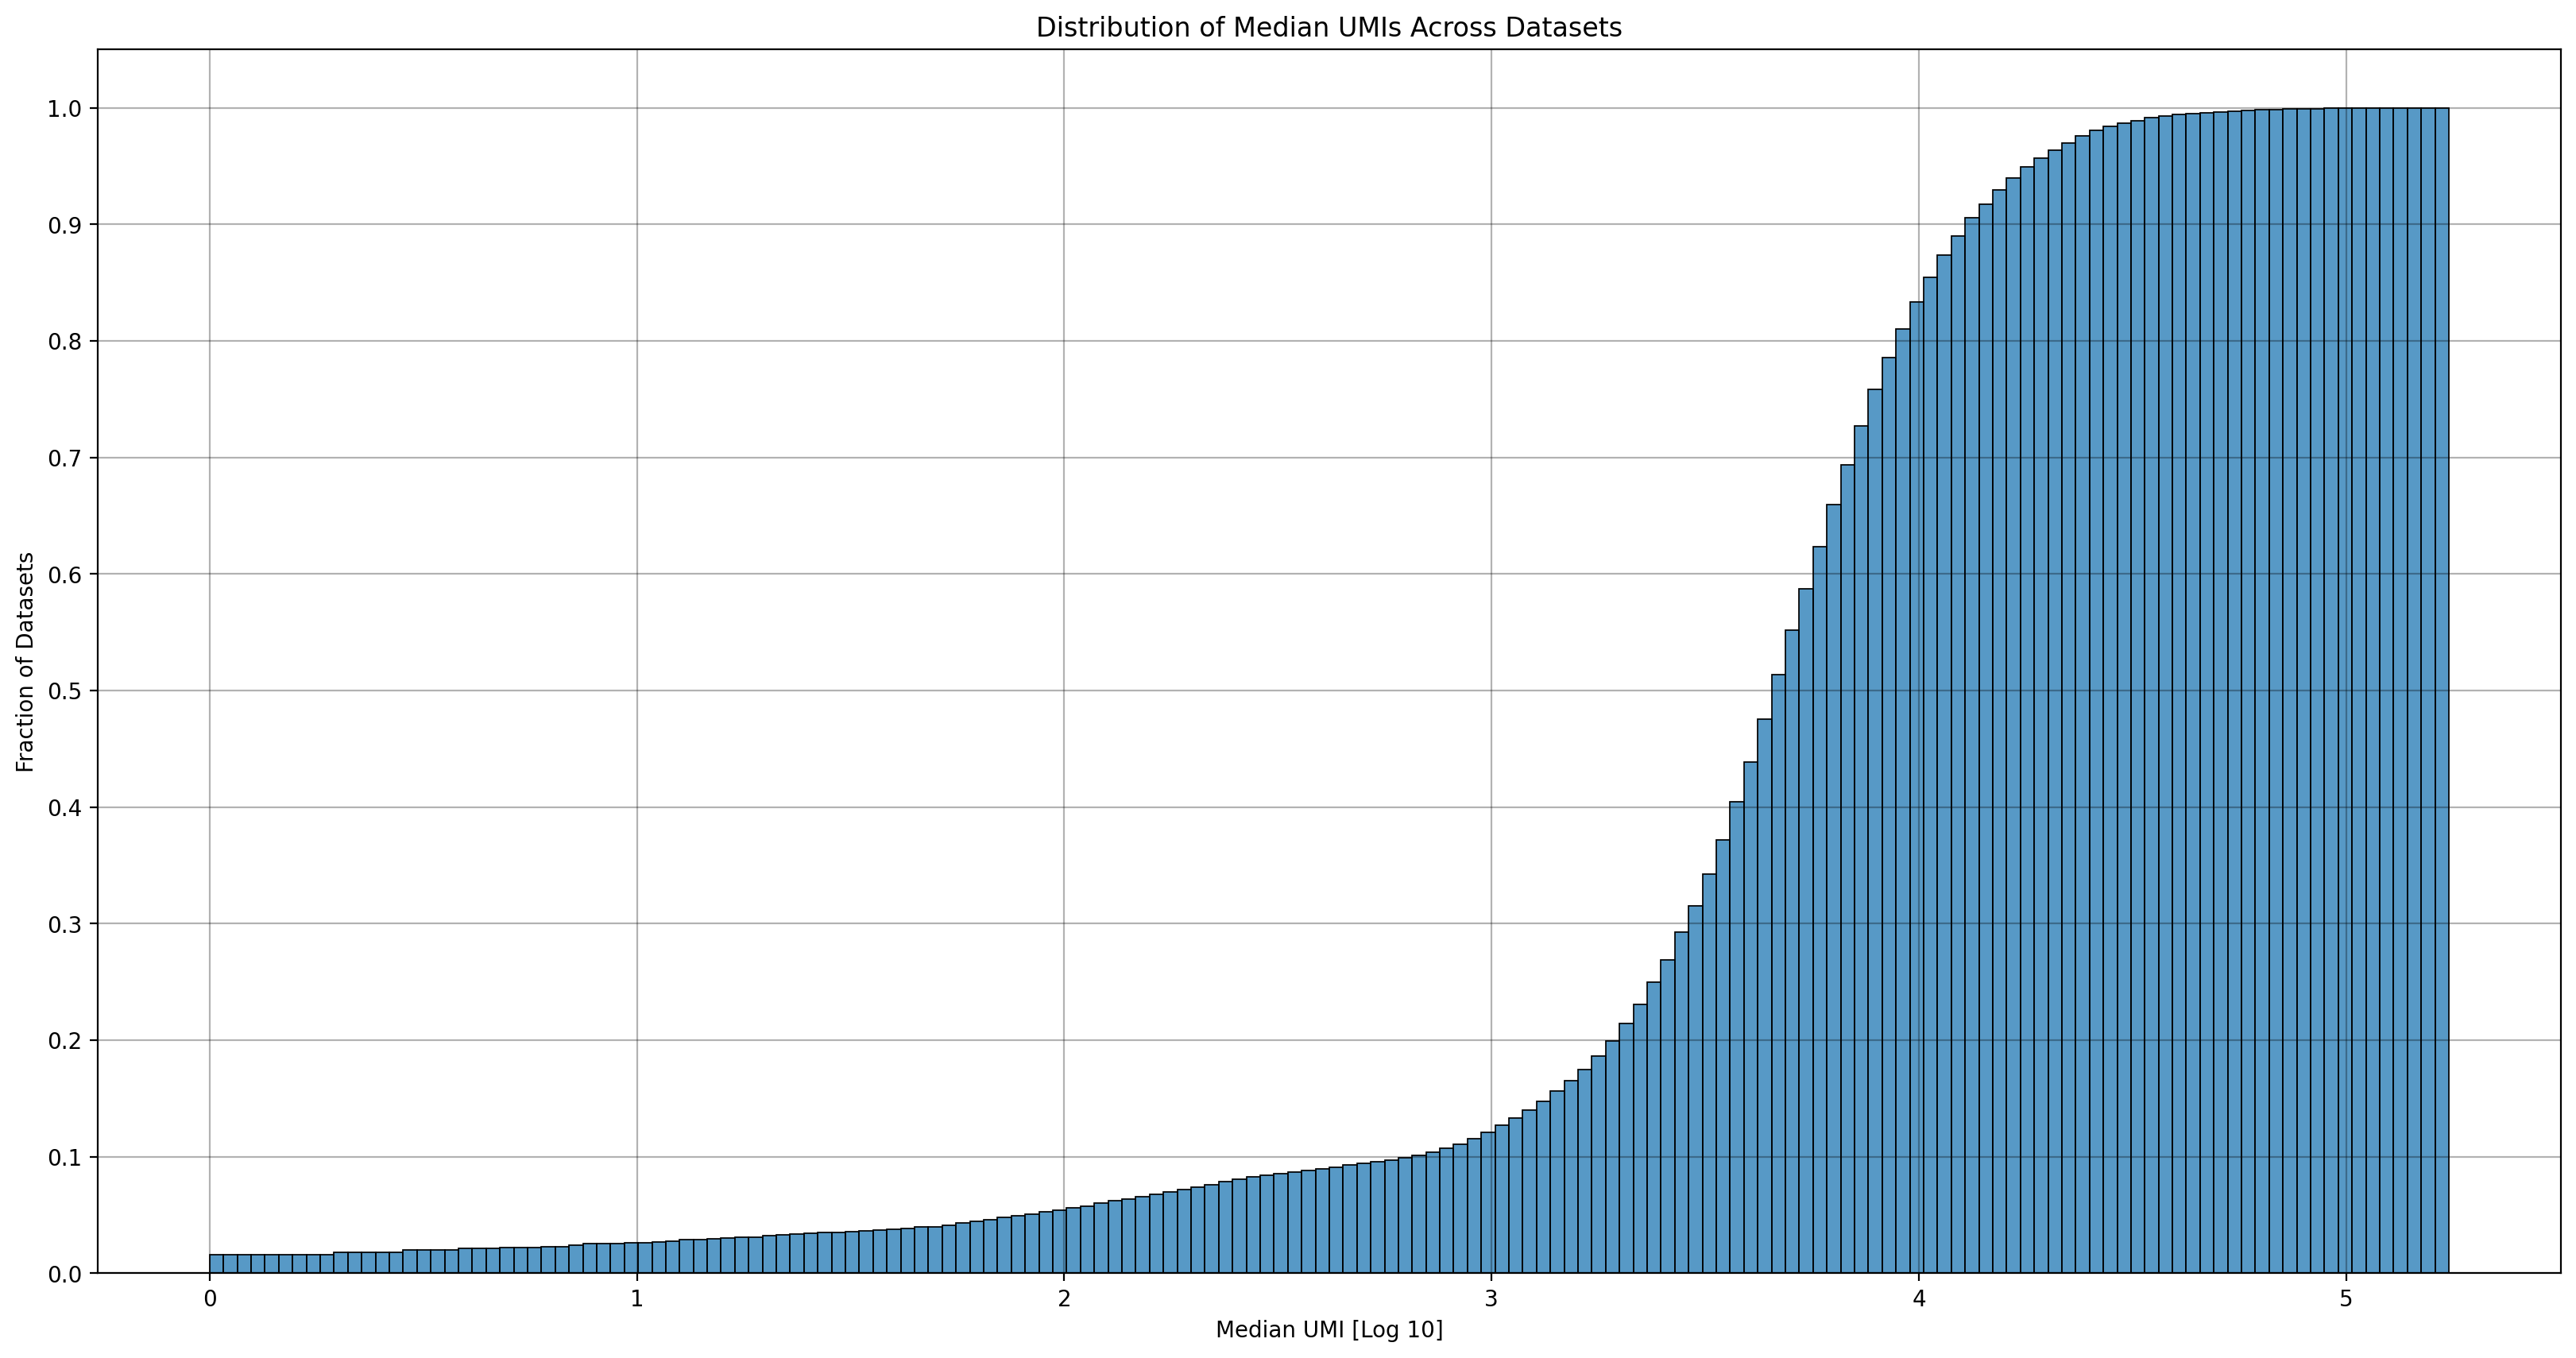

In [6]:
import numpy as np
import seaborn as sns

plt.figure(figsize=(20, 10), dpi=200)
sns.histplot(
    data=stats_data.with_columns(log_med=pl.col("med").log10()),
    x="log_med",
    cumulative=True,
    fill=True,
    stat="probability",
    # hue="species",
    common_norm=False,
)
plt.grid(which="both", color="black", alpha=0.3)
plt.yticks(np.linspace(0, 1.0, 11).round(1))
plt.ylabel("Fraction of Datasets")
plt.xlabel("Median UMI [Log 10]")
plt.title("Distribution of Median UMIs Across Datasets")
plt.show()

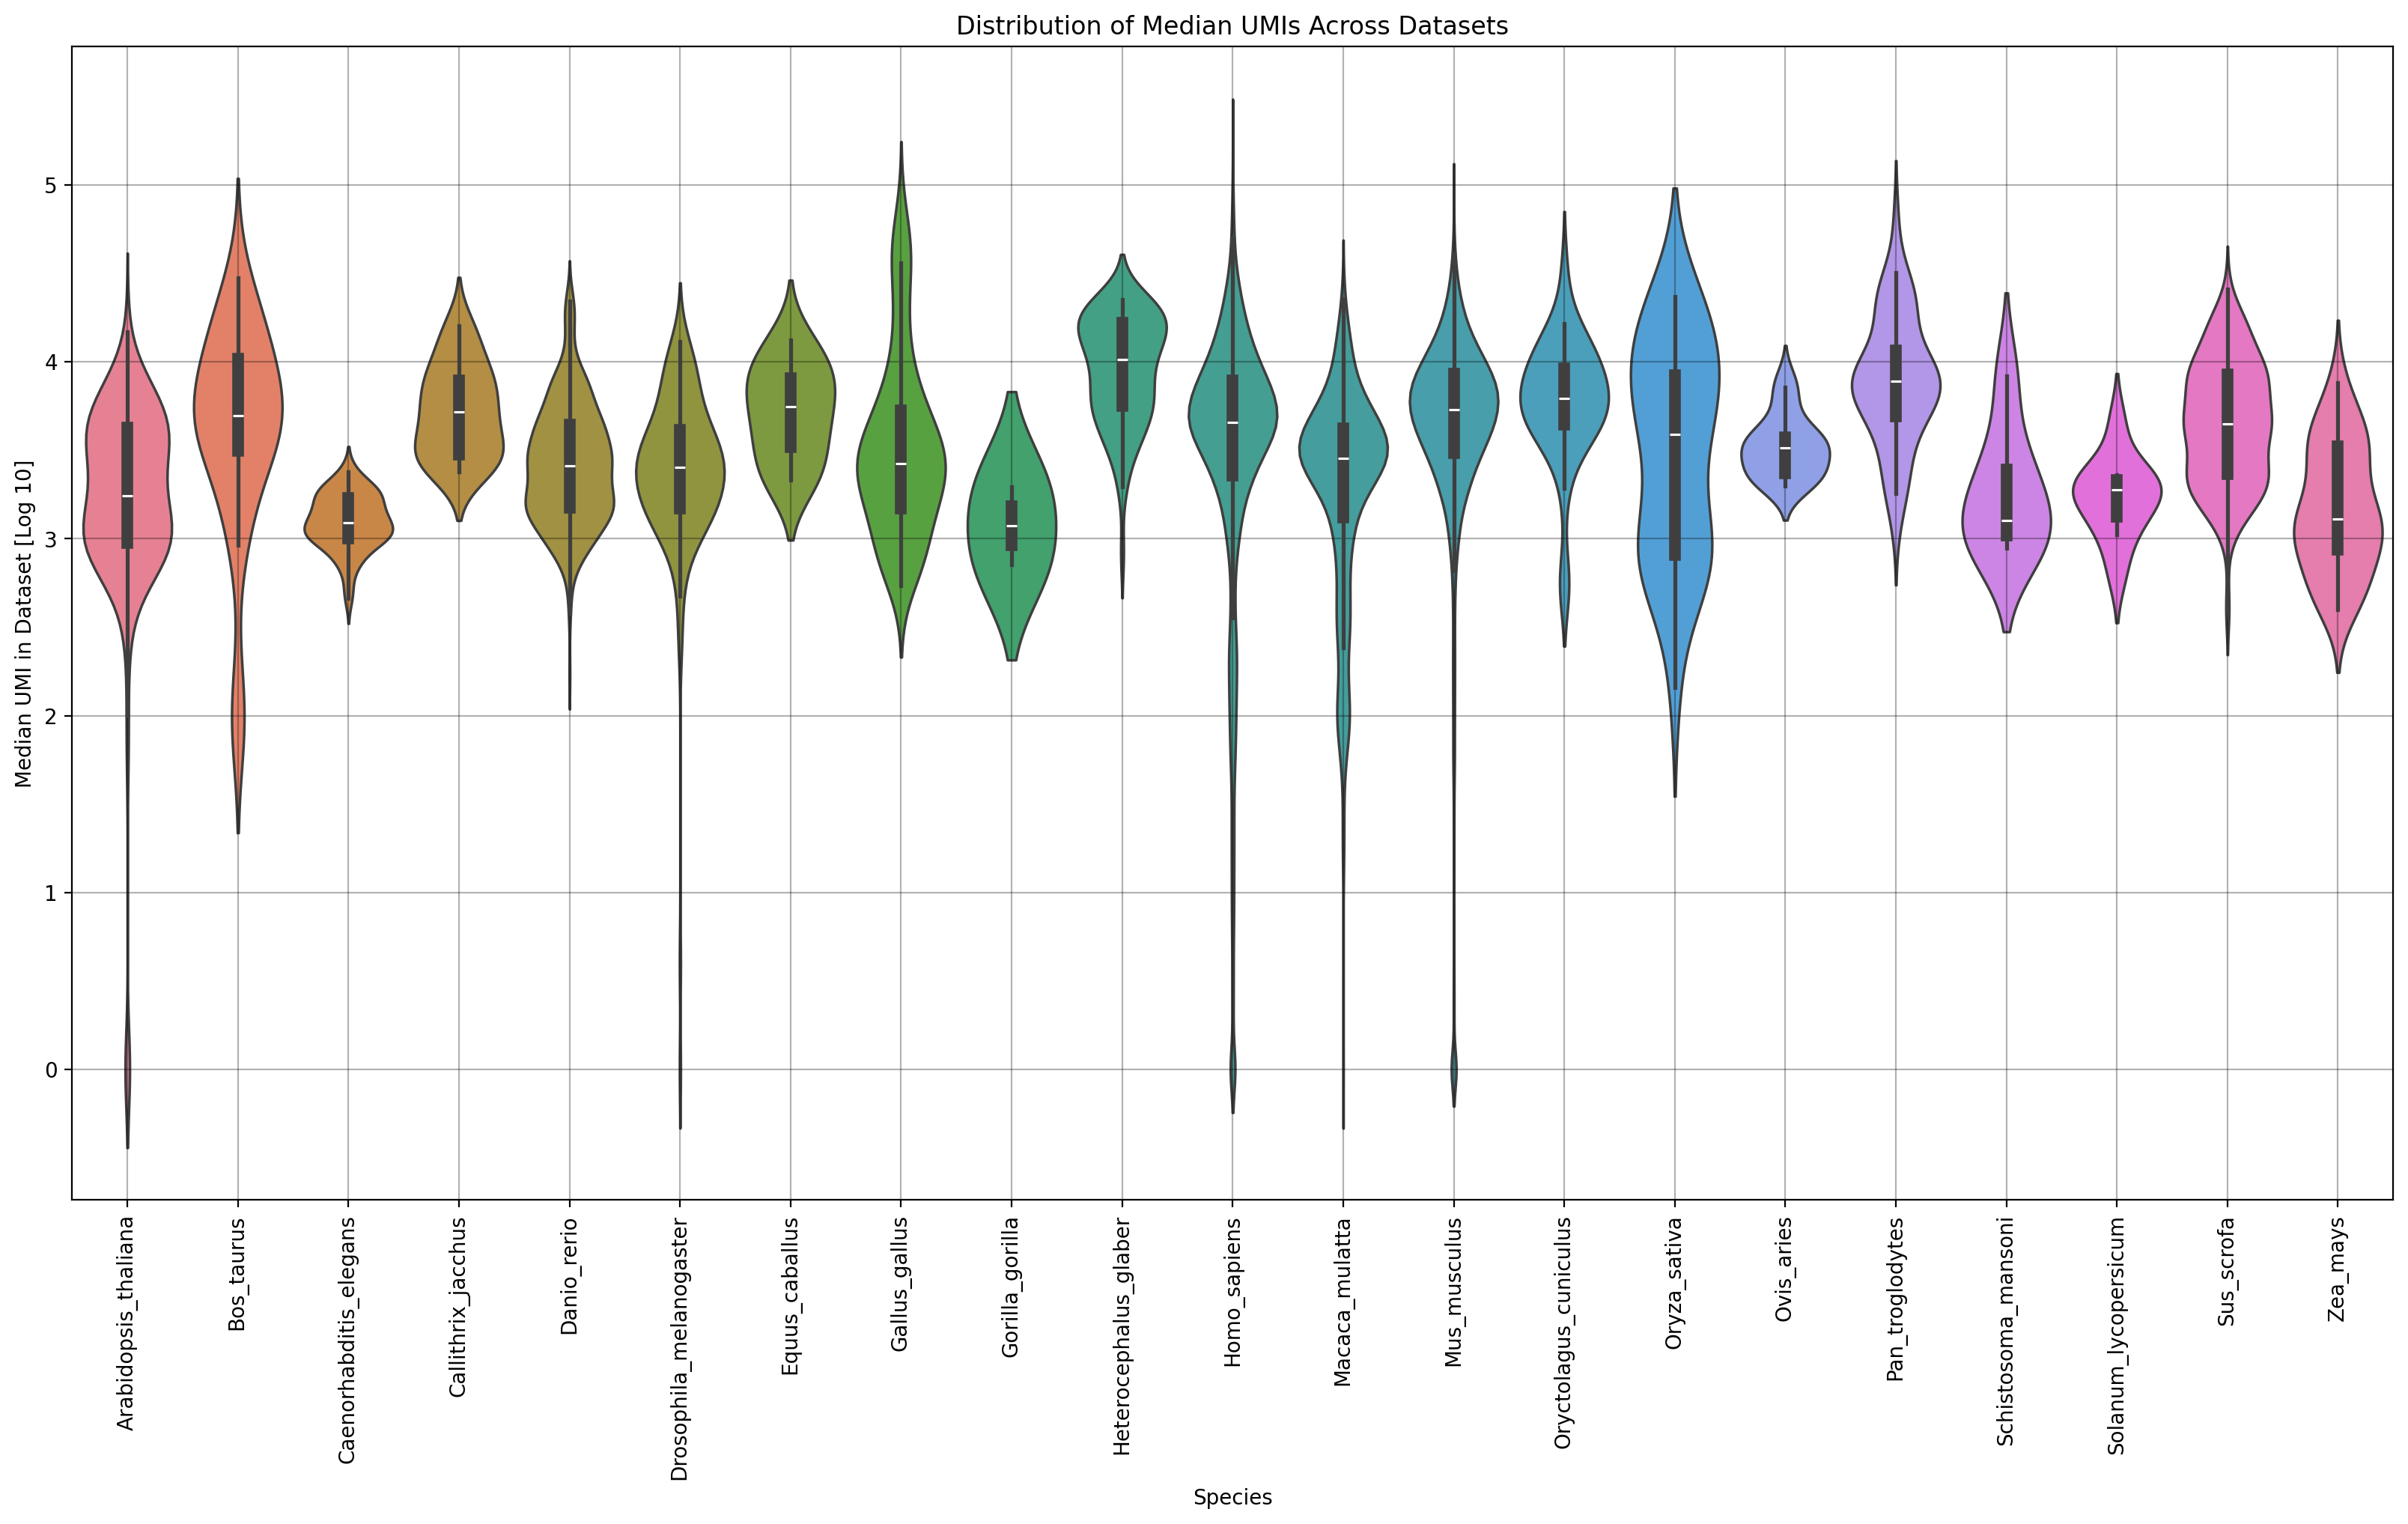

In [7]:
plt.figure(figsize=(20, 10), dpi=200)
sns.violinplot(
    data=stats_data.with_columns(log_med=pl.col("med").log10()),
    x="species",
    y="log_med",
    # cumulative=True,
    fill=True,
    # stat="probability",
    hue="species",
    # common_norm=False,
)
plt.grid(which="both", color="black", alpha=0.3)
# plt.yticks(
#     np.linspace(0, 1.0, 11).round(1)
# )
plt.xticks(rotation=90)
plt.ylabel("Median UMI in Dataset [Log 10]")
plt.xlabel("Species")
plt.title("Distribution of Median UMIs Across Datasets")
plt.show()

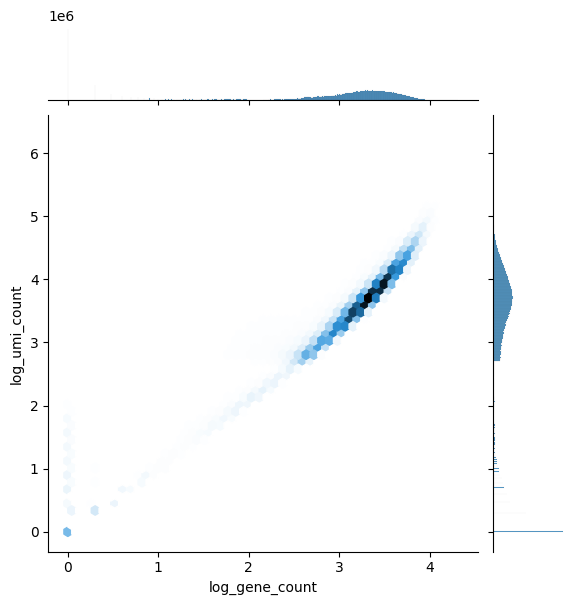

In [8]:
subset = frame.sample(fraction=0.20).with_columns(
    log_umi_count=pl.col("umi_count").log10(),
    log_gene_count=pl.col("gene_count").log10(),
)

sns.jointplot(
    data=subset,
    x="log_gene_count",
    y="log_umi_count",
    kind="hex",
)

In [9]:
frame

cid,gene_count,umi_count,SRX_accession,species
i64,i64,f32,cat,str
0,279,589.0,"""SRX20568526""","""Homo_sapiens"""
1,723,1480.0,"""SRX20568526""","""Homo_sapiens"""
2,1227,3903.0,"""SRX20568526""","""Homo_sapiens"""
3,10469,157686.0,"""SRX20568526""","""Homo_sapiens"""
4,6524,37051.0,"""SRX20568526""","""Homo_sapiens"""
…,…,…,…,…
10726,613,801.0,"""SRX14578794""","""Mus_musculus"""
10727,583,731.0,"""SRX14578794""","""Mus_musculus"""
10728,874,1409.0,"""SRX14578794""","""Mus_musculus"""


In [18]:
min_umi_count = 500
min_gene_count = 300

filtered = frame.filter(
    (pl.col("gene_count") > min_gene_count) & (pl.col("umi_count") > min_umi_count)
)
filtered

cid,gene_count,umi_count,SRX_accession,species
i64,i64,f32,cat,str
1,723,1480.0,"""SRX20568526""","""Homo_sapiens"""
2,1227,3903.0,"""SRX20568526""","""Homo_sapiens"""
3,10469,157686.0,"""SRX20568526""","""Homo_sapiens"""
4,6524,37051.0,"""SRX20568526""","""Homo_sapiens"""
5,444,894.0,"""SRX20568526""","""Homo_sapiens"""
…,…,…,…,…
10726,613,801.0,"""SRX14578794""","""Mus_musculus"""
10727,583,731.0,"""SRX14578794""","""Mus_musculus"""
10728,874,1409.0,"""SRX14578794""","""Mus_musculus"""


In [19]:
dataset_size = (
    filtered.group_by(["species", "SRX_accession"])
    .len()
    .with_columns(log_len=pl.col("len").log10())
)
dataset_size

species,SRX_accession,len,log_len
str,cat,u32,f64
"""Mus_musculus""","""SRX14787119""",2676,3.427486
"""Mus_musculus""","""SRX15855611""",2756,3.440279
"""Homo_sapiens""","""SRX23867625""",7424,3.870638
"""Homo_sapiens""","""SRX18356781""",7960,3.900913
"""Homo_sapiens""","""SRX17689207""",3741,3.572988
…,…,…,…
"""Homo_sapiens""","""SRX14891758""",9784,3.990516
"""Danio_rerio""","""SRX26737880""",2452,3.38952
"""Mus_musculus""","""SRX11029144""",2070,3.31597


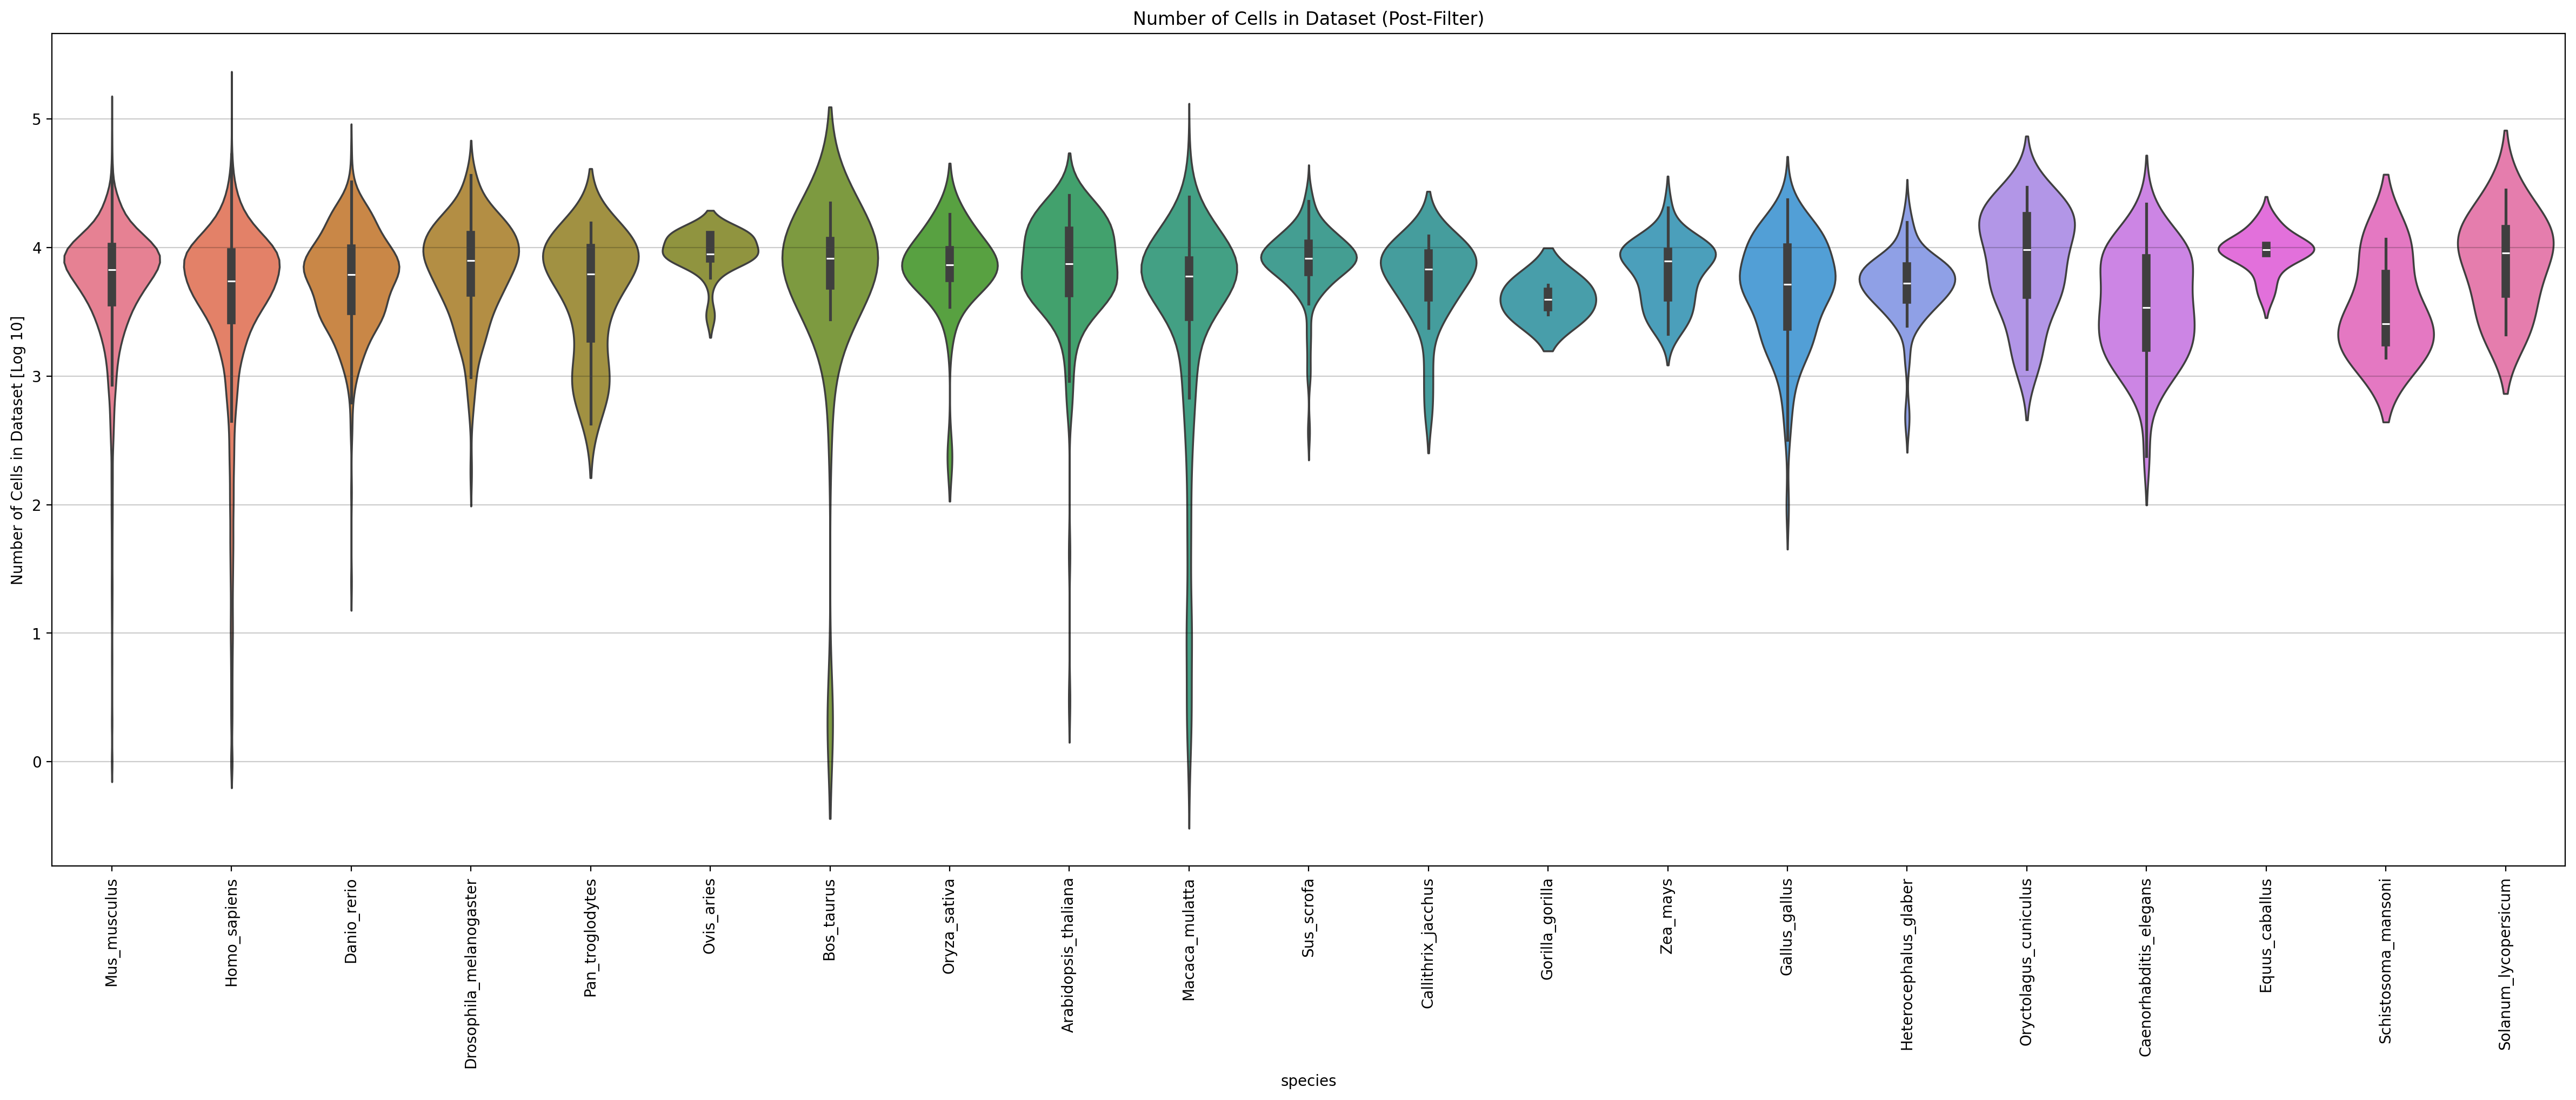

In [20]:
plt.figure(figsize=(30, 10), dpi=200)
sns.violinplot(
    data=dataset_size,
    x="species",
    y="log_len",
    hue="species",
)
plt.ylabel("Number of Cells in Dataset [Log 10]")
plt.xticks(rotation=90)
plt.grid(which="both", axis="y", color="black", alpha=0.2)
plt.title("Number of Cells in Dataset (Post-Filter)")
plt.show()

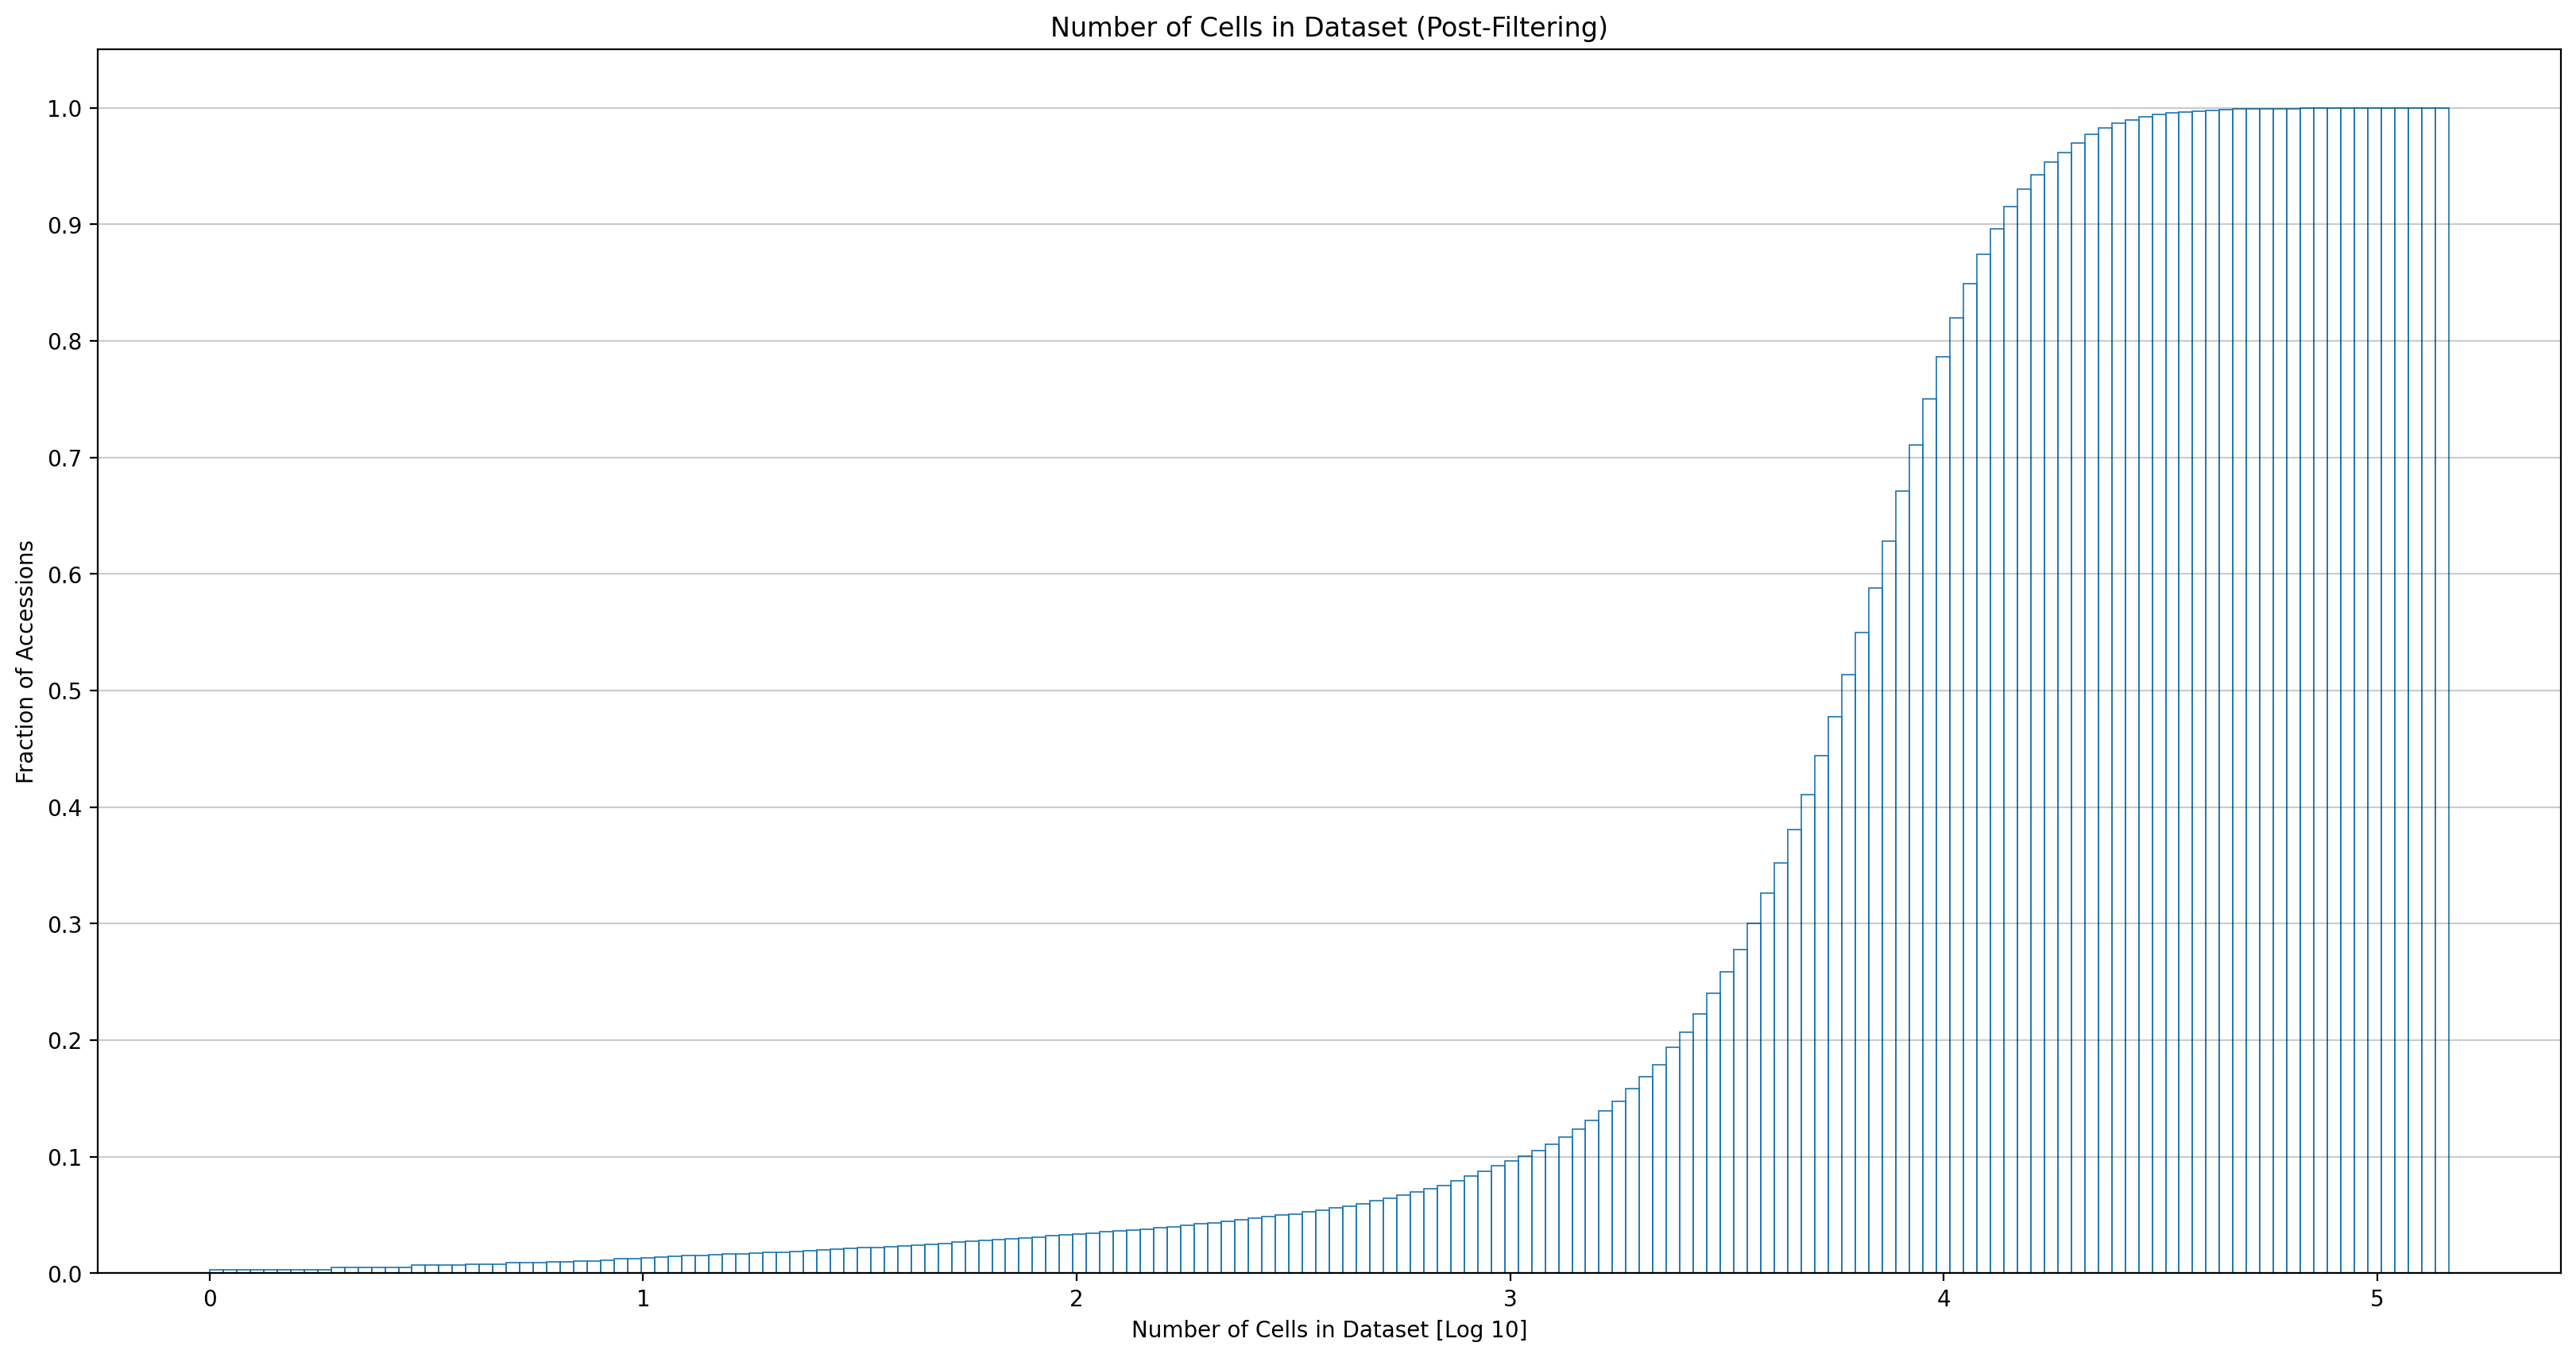

In [21]:
plt.figure(figsize=(20, 10), dpi=200)
sns.histplot(
    data=dataset_size,
    x="log_len",
    cumulative=True,
    fill=False,
    stat="probability",
)
plt.yticks(np.linspace(0, 1, 11))
plt.grid(which="both", color="black", alpha=0.2, axis="y")
plt.title("Number of Cells in Dataset (Post-Filtering)")
plt.xlabel("Number of Cells in Dataset [Log 10]")
plt.ylabel("Fraction of Accessions")
plt.show()

In [22]:
passing_datasets = dataset_size.filter(pl.col("len") >= 500)
passing_datasets

species,SRX_accession,len,log_len
str,cat,u32,f64
"""Mus_musculus""","""SRX14787119""",2676,3.427486
"""Mus_musculus""","""SRX15855611""",2756,3.440279
"""Homo_sapiens""","""SRX23867625""",7424,3.870638
"""Homo_sapiens""","""SRX18356781""",7960,3.900913
"""Homo_sapiens""","""SRX17689207""",3741,3.572988
…,…,…,…
"""Homo_sapiens""","""SRX14891758""",9784,3.990516
"""Danio_rerio""","""SRX26737880""",2452,3.38952
"""Mus_musculus""","""SRX11029144""",2070,3.31597


In [23]:
passing_datasets.shape[0] / dataset_size.shape[0]

0.9382920680962741

In [24]:
extra_filtered = filtered.join(
    passing_datasets, on=["species", "SRX_accession"], how="inner"
)
extra_filtered

cid,gene_count,umi_count,SRX_accession,species,len,log_len
i64,i64,f32,cat,str,u32,f64
1,723,1480.0,"""SRX20568526""","""Homo_sapiens""",2736,3.437116
2,1227,3903.0,"""SRX20568526""","""Homo_sapiens""",2736,3.437116
3,10469,157686.0,"""SRX20568526""","""Homo_sapiens""",2736,3.437116
4,6524,37051.0,"""SRX20568526""","""Homo_sapiens""",2736,3.437116
5,444,894.0,"""SRX20568526""","""Homo_sapiens""",2736,3.437116
…,…,…,…,…,…,…
10726,613,801.0,"""SRX14578794""","""Mus_musculus""",10715,4.029992
10727,583,731.0,"""SRX14578794""","""Mus_musculus""",10715,4.029992
10728,874,1409.0,"""SRX14578794""","""Mus_musculus""",10715,4.029992


In [25]:
extra_filtered.shape[0] / frame.shape[0]

0.892036223287218

In [29]:
out_csv = f"{out_dir}/../passing_datasets.tsv"
passing_datasets.write_csv(out_csv, separator="\t")